In [1]:
from comet_ml import API, APIExperiment
from comet_ml.api import Metric, Metadata, Parameter

In [2]:
API_KEY = "fV5dK3zd6LZtaRxbPqx5dc0n0"
WORKSPACE = "real"
PROJECT_NAME = "surprise-adaptive-agents"
SAVE_DIR = "/home/ahugessen/Documents/Papers/Surprise Adapt"

In [3]:
api = API(api_key=API_KEY)

In [4]:
api.get(WORKSPACE)

['surprise-adaptive-agents', 'audio-urbansound8k', 'nlp-twitter-airline']

In [5]:
! pip install seaborn

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


### Tetris

In [248]:
query = (Parameter("env")=='Tetris') & (Parameter("doodad_run_mode") =="local") & (Metadata("start_server_timestamp") > datetime(2023, 5, 29, 0))

In [249]:
experiments = api.get_experiments(workspace="real", project_name="surprise-adaptive-agents", pattern="Tetris_RandomAgent_final")

In [250]:
experiments = experiments + api.query(workspace=WORKSPACE, project_name=PROJECT_NAME, query=query)

In [251]:
query = (Parameter("env")=='Tetris') & (Parameter("doodad_run_mode") =="local") & (Parameter("exp_name") =="SMin_final")

In [252]:
experiments=experiments + api.query(workspace=WORKSPACE, project_name=PROJECT_NAME, query=query)

In [253]:
query = (Parameter("env")=='Tetris') & (Parameter("doodad_run_mode") =="local") & (Parameter("exp_name") =="SMax_final")

In [254]:
experiments=experiments + api.query(workspace=WORKSPACE, project_name=PROJECT_NAME, query=query)

In [255]:
for experiment in experiments:
    print(experiment.get_metadata()["experimentName"])

Tetris_RandomAgent_final
Tetris_RandomAgent_final
Tetris_RandomAgent_final
Tetris_SAv2deltabin_nomon_final
Tetris_SAv2deltabin_nomon_final
Tetris_SAv2deltabin_nomon_final
Tetris_SAv2deltabin_final
Tetris_SAv2deltabin_final
Tetris_SAv2deltabin_final
Tetris_SMin_final
Tetris_SMin_final
Tetris_SMin_final
Tetris_SMax_final
Tetris_SMax_final
Tetris_SMax_final


In [256]:
keys = [experiment.get_metadata()['experimentKey'] for experiment in experiments]
data = api.get_metrics_for_chart(keys, 
                                 metrics=["evaluation/env_infos/surprise Mean", 
                                          "evaluation/env_infos/task_reward Mean",
                                         "Epoch"],
                                parameters=['random_seed'])

In [257]:
metrics_df = pd.DataFrame()
for key, metrics in data.items():
    experiment = api.get_experiment_by_key(experiment_key=key)
    experiment_name = experiment.get_metadata()["experimentName"]
    seed = metrics['params']['random_seed']
    for metric in metrics['metrics']:
        temp_df = pd.DataFrame(metric)
        if temp_df['metricName'][0] != 'Epoch':
            temp_df['values'] = temp_df['values'].rolling(10, center=True).mean()
        temp_df['seed'] = seed
        temp_df['experiment'] = experiment_name
        metrics_df = pd.concat([metrics_df, temp_df])

In [258]:
metrics_df = metrics_df[['metricName', 'steps', 'seed', 'experiment', 'values']]

In [259]:
metrics_df.head(10)

,metricName,steps,seed,experiment,values
0,evaluation/env_infos/surprise Mean,1000,2,Tetris_SMax_final,NaN
1,evaluation/env_infos/surprise Mean,1003,2,Tetris_SMax_final,NaN
2,evaluation/env_infos/surprise Mean,1011,2,Tetris_SMax_final,NaN
3,evaluation/env_infos/surprise Mean,1013,2,Tetris_SMax_final,NaN
4,evaluation/env_infos/surprise Mean,1031,2,Tetris_SMax_final,NaN
5,evaluation/env_infos/surprise Mean,1050,2,Tetris_SMax_final,19.875104
6,evaluation/env_infos/surprise Mean,1059,2,Tetris_SMax_final,20.186875
7,evaluation/env_infos/surprise Mean,1070,2,Tetris_SMax_final,20.143124
8,evaluation/env_infos/surprise Mean,1072,2,Tetris_SMax_final,20.659361
9,evaluation/env_infos/surprise Mean,1074,2,Tetris_SMax_final,20.965829


In [260]:
metrics_df = metrics_df[metrics_df.metricName != 'Epoch'].merge(metrics_df[metrics_df.metricName=='Epoch'].drop('metricName', axis=1),
                                                   on=['steps', 'steps', 'seed', 'experiment'],
                                                  suffixes=['', '_epoch'])
metrics_df['env_steps'] = metrics_df.values_epoch*1000

In [261]:
metrics_df.head(10)

,metricName,steps,seed,experiment,values,values_epoch,env_steps
0,evaluation/env_infos/surprise Mean,1000,2,Tetris_SMax_final,NaN,0.0,0.0
1,evaluation/env_infos/task_reward Mean,1000,2,Tetris_SMax_final,NaN,0.0,0.0
2,evaluation/env_infos/surprise Mean,1003,2,Tetris_SMax_final,NaN,3.0,3000.0
3,evaluation/env_infos/task_reward Mean,1003,2,Tetris_SMax_final,NaN,3.0,3000.0
4,evaluation/env_infos/surprise Mean,1013,2,Tetris_SMax_final,NaN,13.0,13000.0
5,evaluation/env_infos/task_reward Mean,1013,2,Tetris_SMax_final,NaN,13.0,13000.0
6,evaluation/env_infos/surprise Mean,1031,2,Tetris_SMax_final,NaN,31.0,31000.0
7,evaluation/env_infos/task_reward Mean,1031,2,Tetris_SMax_final,NaN,31.0,31000.0
8,evaluation/env_infos/surprise Mean,1050,2,Tetris_SMax_final,19.875104,50.0,50000.0
9,evaluation/env_infos/task_reward Mean,1050,2,Tetris_SMax_final,-14.365000,50.0,50000.0


In [262]:
metrics_df.experiment = metrics_df.experiment.replace({'Tetris_SAv2deltabin_nomon_final': "S-Adapt-IM (Ours)",
                                                      'Tetris_SAv2deltabin_final': 'S-Adapt (Ours)',
                                                      'Tetris_SMax_final': 'S-Max',
                                                      'Tetris_SMin_final': 'S-Min',
                                                      'Tetris_RandomAgent_final': 'Random'})

In [263]:
metrics_df.head()

,metricName,steps,seed,experiment,values,values_epoch,env_steps
0,evaluation/env_infos/surprise Mean,1000,2,S-Max,NaN,0.0,0.0
1,evaluation/env_infos/task_reward Mean,1000,2,S-Max,NaN,0.0,0.0
2,evaluation/env_infos/surprise Mean,1003,2,S-Max,NaN,3.0,3000.0
3,evaluation/env_infos/task_reward Mean,1003,2,S-Max,NaN,3.0,3000.0
4,evaluation/env_infos/surprise Mean,1013,2,S-Max,NaN,13.0,13000.0


In [264]:
metrics_df.groupby(['metricName', 'seed', 'experiment']).values.count()

metricName                             seed  experiment       
evaluation/env_infos/surprise Mean     0     Random               491
                                             S-Adapt (Ours)       491
                                             S-Adapt-IM (Ours)    491
                                             S-Max                492
                                             S-Min                492
                                       1     Random               491
                                             S-Adapt (Ours)       491
                                             S-Adapt-IM (Ours)    490
                                             S-Max                491
                                             S-Min                492
                                       2     Random               491
                                             S-Adapt (Ours)       491
                                             S-Adapt-IM (Ours)    489
                           

In [265]:
metrics_df = metrics_df.sort_values(by="experiment")

In [270]:
metrics_df = metrics_df[metrics_df['env_steps'] < 6500000]

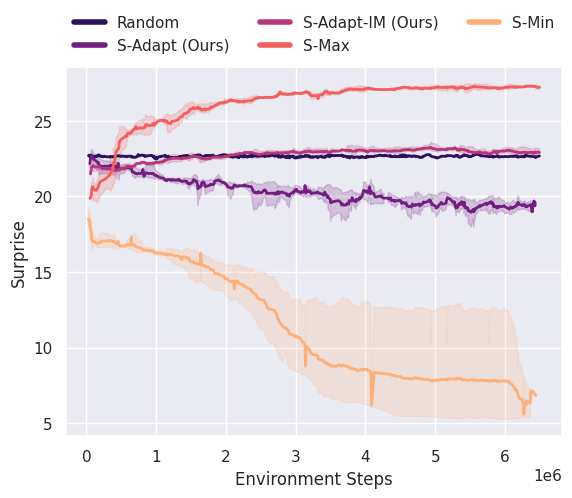

In [271]:
sns.set(font_scale=1)
ax = sns.lineplot(metrics_df[(metrics_df.metricName=='evaluation/env_infos/surprise Mean')], 
             y="values", x="env_steps", hue="experiment", palette="magma", lw=2)
leg = ax.legend()
for line in leg.get_lines():
    line.set_linewidth(4.0)
sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False)
ax.set(xlabel="Environment Steps", ylabel='Surprise')
plt.savefig(f"{SAVE_DIR}/tetris_surprise.png")

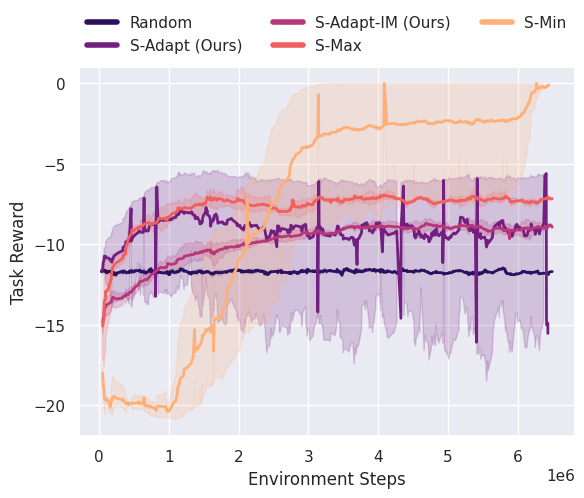

In [272]:
sns.set(font_scale=1)
ax = sns.lineplot(metrics_df[(metrics_df.metricName=='evaluation/env_infos/task_reward Mean')], 
             y="values", x="env_steps", hue="experiment", palette="magma", lw=2)
leg = ax.legend()
for line in leg.get_lines():
    line.set_linewidth(4.0)
sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False)
ax.set(xlabel="Environment Steps", ylabel='Task Reward')
plt.savefig(f"{SAVE_DIR}/tetris_reward.png")

### Maze

In [273]:
from datetime import datetime

In [274]:
experiments = api.get_experiments(workspace="real", project_name="surprise-adaptive-agents", pattern="MazeEnvFullyObserved_SMAX_final")

In [275]:
query = (Parameter("env") == "MazeEnvFullyObserved") & (Metadata("start_server_timestamp") > datetime(2023, 5, 28, 0))

In [276]:
experiments = experiments + api.query(workspace=WORKSPACE, project_name=PROJECT_NAME, query=query)

In [277]:
experiments = api.query(workspace=WORKSPACE, project_name=PROJECT_NAME, query=query)

In [278]:
for experiment in experiments:
    print(experiment.get_metadata()["experimentName"])

MazeEnvFullyObserved_SMin_final
MazeEnvFullyObserved_SMin_final
MazeEnvFullyObserved_SMin_final
MazeEnvFullyObserved_RandomAgent_final
MazeEnvFullyObserved_RandomAgent_final
MazeEnvFullyObserved_RandomAgent_final
MazeEnvFullyObserved_SA_no_momentum_deltabin
MazeEnvFullyObserved_SA_no_momentum_deltabin
MazeEnvFullyObserved_SA_momentum_deltabin_final
MazeEnvFullyObserved_SMax_final
MazeEnvFullyObserved_SA_no_momentum_deltabin
MazeEnvFullyObserved_SMax_final
MazeEnvFullyObserved_SMax_final
MazeEnvFullyObserved_SA_momentum_deltabin_final
MazeEnvFullyObserved_SA_momentum_deltabin_final


In [279]:
import pandas as pd

In [280]:
keys = [experiment.get_metadata()['experimentKey'] for experiment in experiments]
data = api.get_metrics_for_chart(keys, 
                                 metrics=["evaluation/env_infos/surprise Mean", 
                                          "evaluation/env_infos/task_reward Mean",
                                         "Epoch"],
                                parameters=['random_seed'])

In [281]:
metrics_df = pd.DataFrame()
for key, metrics in data.items():
    experiment = api.get_experiment_by_key(experiment_key=key)
    experiment_name = experiment.get_metadata()["experimentName"]
    seed = metrics['params']['random_seed']
    for metric in metrics['metrics']:
        temp_df = pd.DataFrame(metric)
        if temp_df['metricName'][0] != 'Epoch':
            temp_df['values'] = temp_df['values'].rolling(10, center=True).mean()
        temp_df['seed'] = seed
        temp_df['experiment'] = experiment_name
        metrics_df = pd.concat([metrics_df, temp_df])

In [282]:
metrics_df = metrics_df[['metricName', 'steps', 'seed', 'experiment', 'values']]

In [283]:
metrics_df = metrics_df[metrics_df.metricName != 'Epoch'].merge(metrics_df[metrics_df.metricName=='Epoch'].drop('metricName', axis=1),
                                                   on=['steps', 'steps', 'seed', 'experiment'],
                                                  suffixes=['', '_epoch'])
metrics_df['env_steps'] = metrics_df.values_epoch*1000

In [284]:
metrics_df.groupby(['metricName', 'seed', 'experiment']).values.count()

metricName                             seed  experiment                                     
evaluation/env_infos/surprise Mean     0     MazeEnvFullyObserved_RandomAgent_final             491
                                             MazeEnvFullyObserved_SA_momentum_deltabin_final    492
                                             MazeEnvFullyObserved_SA_no_momentum_deltabin       492
                                             MazeEnvFullyObserved_SMax_final                    491
                                             MazeEnvFullyObserved_SMin_final                    492
                                       1     MazeEnvFullyObserved_RandomAgent_final             491
                                             MazeEnvFullyObserved_SA_momentum_deltabin_final    491
                                             MazeEnvFullyObserved_SA_no_momentum_deltabin       491
                                             MazeEnvFullyObserved_SMax_final                    492
       

In [285]:
metrics_df.head()

,metricName,steps,seed,experiment,values,values_epoch,env_steps
0,evaluation/env_infos/surprise Mean,1000,2,MazeEnvFullyObserved_RandomAgent_final,NaN,0.0,0.0
1,evaluation/env_infos/task_reward Mean,1000,2,MazeEnvFullyObserved_RandomAgent_final,NaN,0.0,0.0
2,evaluation/env_infos/surprise Mean,1002,2,MazeEnvFullyObserved_RandomAgent_final,NaN,2.0,2000.0
3,evaluation/env_infos/task_reward Mean,1002,2,MazeEnvFullyObserved_RandomAgent_final,NaN,2.0,2000.0
4,evaluation/env_infos/surprise Mean,1003,2,MazeEnvFullyObserved_RandomAgent_final,NaN,3.0,3000.0


In [286]:
metrics_df.experiment = metrics_df.experiment.replace({'MazeEnvFullyObserved_SA_no_momentum_deltabin': "S-Adapt-IM",
                                                      'MazeEnvFullyObserved_SA_momentum_deltabin_final': 'S-Adapt',
                                                      'MazeEnvFullyObserved_SMax_final': 'S-Max',
                                                      'MazeEnvFullyObserved_SMin_final': 'S-Min',
                                                      'MazeEnvFullyObserved_RandomAgent_final': 'Random'})

In [287]:
metrics_df = metrics_df.sort_values(by="experiment")

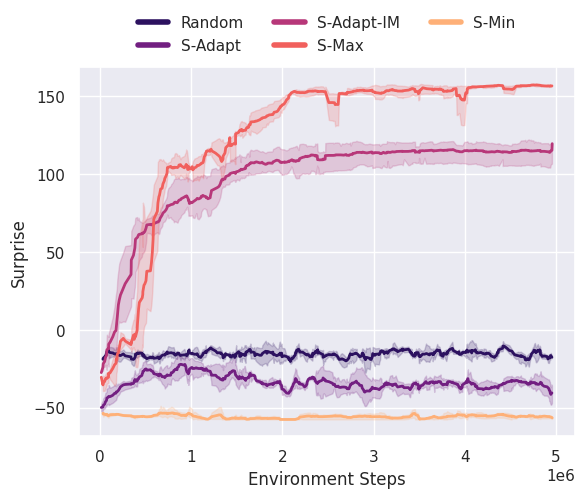

In [288]:
sns.set(font_scale=1)
ax = sns.lineplot(metrics_df[(metrics_df.metricName=='evaluation/env_infos/surprise Mean')], 
             y="values", x="env_steps", hue="experiment", palette="magma", lw=2)
leg = ax.legend()
for line in leg.get_lines():
    line.set_linewidth(4.0)
sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False)
ax.set(xlabel="Environment Steps", ylabel='Surprise')
plt.savefig(f"{SAVE_DIR}/maze_surprise.png")

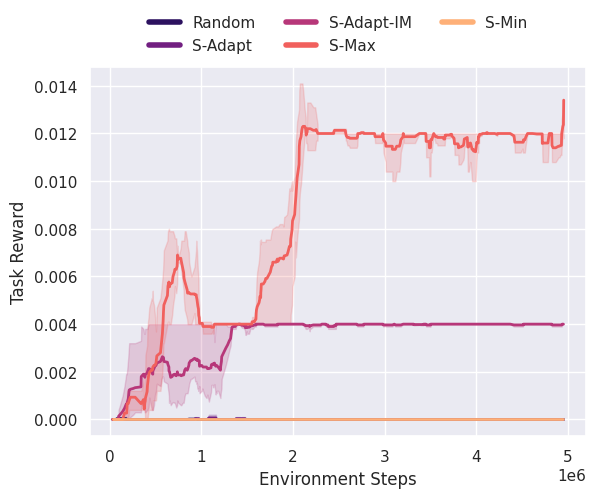

In [289]:
sns.set(font_scale=1)
ax = sns.lineplot(metrics_df[(metrics_df.metricName=='evaluation/env_infos/task_reward Mean')], 
             y="values", x="env_steps", hue="experiment", palette="magma", lw=2)
ax.set(xlabel="Environment Steps", ylabel='Task Reward')
leg = ax.legend()
for line in leg.get_lines():
    line.set_linewidth(4.0)
sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False)
plt.savefig(f"{SAVE_DIR}/maze_reward.png")